<a href="https://colab.research.google.com/github/Osterne/codes_book/blob/main/episodio_03_curva_roc_auc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

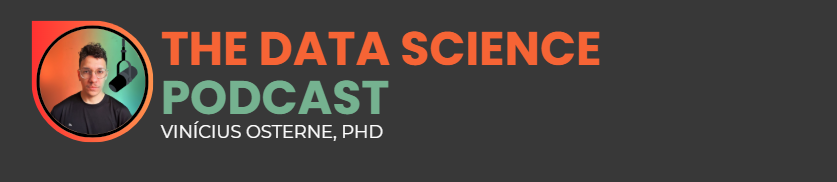


# Episódio 03 - Curva ROC (AUC)

## Dúvida de um seguidor

“Professor, eu sempre vejo gente falando de curva ROC quando explicam modelos de machine learning, mas eu não entendo bem. Se eu já tenho a acurácia ou até a matriz de confusão, por que eu preciso dessa curva ROC? Ela realmente ajuda a entender se o modelo está bom para detectar fraudes? E o que significam aqueles pontos de sensibilidade e taxa de falso positivo que aparecem no gráfico?”

## Análise

In [66]:
!pip install h2o

In [67]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import h2o
from h2o.estimators import H2OGradientBoostingEstimator

In [68]:
# ===============================
# Base artificial mais difícil
# ===============================
import numpy as np
import pandas as pd

np.random.seed(42)
n_samples = 2000

# Variáveis comportamentais
transacoes_24h = np.random.poisson(lam=2, size=n_samples)               # discreta
dispositivos = np.random.randint(1, 5, n_samples)                       # discreta
tentativas_senha = np.random.poisson(lam=1, size=n_samples)              # discreta

# Variáveis contínuas
tempo_sessao = np.random.exponential(scale=300, size=n_samples)          # tempo de sessão em segundos
valor_medio_transacao = np.random.normal(loc=500, scale=200, size=n_samples)  # valor médio em R$

# Ajuste para manter valores positivos
valor_medio_transacao = np.clip(valor_medio_transacao, 50, None)

# Probabilidade base de fraude
prob_fraude = (
    0.05 +
    0.15 * (tentativas_senha > 2) +
    0.10 * (dispositivos > 2) +
    0.08 * (transacoes_24h < 1) +
    0.10 * (tempo_sessao > 800) +
    0.12 * (valor_medio_transacao > 1000)
)

# Limitando probabilidade entre 0 e 0.95
prob_fraude = np.clip(prob_fraude, 0, 0.95)

# Sorteando fraude com base na probabilidade (ruído incluído)
fraude = np.random.binomial(1, prob_fraude)

# Criar DataFrame
df = pd.DataFrame({
    'transacoes_24h': transacoes_24h,
    'dispositivos': dispositivos,
    'tentativas_senha': tentativas_senha,
    'tempo_sessao': tempo_sessao,
    'valor_medio_transacao': valor_medio_transacao,
    'fraude': fraude
})

In [69]:
# transacoes_24h: número de transações nas últimas 24h (detecta padrões anormais de atividade)
# dispositivos: número de dispositivos diferentes usados para login (Indica possível comprometimento de conta)
# tentativas_senha: tentativas de senha incorreta (Comportamento típico de ataques ou fraude)
# tempo_sessao: tempo de sessão (tempo de uso em segundos)
# valor_medio_transacao: valor medio da transação (valor médio do ticket solicitado em R$)
print("Shape:", df.shape)
display(df.head())

Shape: (2000, 6)


,transacoes_24h,dispositivos,tentativas_senha,tempo_sessao,valor_medio_transacao,fraude
0,4,3,1,662.496647,50.000000,0
1,1,1,1,587.797207,499.227544,0
2,3,2,0,23.949215,385.474599,0
3,3,4,0,33.745217,529.163620,0
4,1,1,1,205.061008,718.525513,0


In [70]:
df["fraude"].mean()

np.float64(0.13)

In [71]:
# ===============================
# Treinar modelo GBM
# ===============================
# Iniciar H2O
h2o.init()

# Converter o dataframe para H2OFrame
hf = h2o.H2OFrame(df)

# Definir features e target (agora incluindo as contínuas)
features = [
    'transacoes_24h',
    'dispositivos',
    'tentativas_senha',
    'tempo_sessao',
    'valor_medio_transacao'
]
target = 'fraude'

# Converter target para categórico (fator)
hf[target] = hf[target].asfactor()

# Treinar modelo GBM
gbm_model = H2OGradientBoostingEstimator(
    ntrees=100,
    max_depth=3,
    learn_rate=0.1,
    seed=42
)
gbm_model.train(x=features, y=target, training_frame=hf)

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,3 hours 16 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,4 months and 4 days
H2O_cluster_name:,H2O_from_python_unknownUser_rnc9bd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.169 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1753980510995_307


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    100                100                         14536                  3            3            3             4             8             6.91

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.09073706034788907
RMSE: 0.30122592907631485
LogLoss: 0.30470785683944324
Mean Per-Class Error: 0.2723032714412025
AUC: 0.8349535809018567
AUCPR: 0.5037986648065483
Gini: 0.6699071618037133

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20329613365414523
       0     1    Error    Rate
-----  ----  ---  -------  --------------
0      1562  178  0.1023   (178.0/1740.0)
1      115   145  0.4423   (115.0/260.0)
Total  1677  323  0.1465   (293.0/2000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.203296     0.497427  151
max f2                       0.145969     0.597484  215
max f0point5                 0.274163     0.526316  98
max accuracy                 0.405463     0.8855    40
max precision                0.803318     1         0
max recall                   0.0332314    1         369
max specificity              0.803318     1         0
max absolute_mcc             0.203296     0.416179  151
max min_per_class_accuracy   0.156554     0.746154  203
max mean_per_class_accuracy  0.145969     0.758245  215
max tns                      0.803318     1740      0
max fns                      0.803318     259       0
max fps                      0.00737087   1740      399
max tps                      0.0332314    260       369
max tnr                      0.803318     1         0
max fnr                      0.803318     0.996154  0
max fpr                      0.00737087   1         399
max tpr                      0.0332314    1         369

Gains/Lift Table: Avg response rate: 13.00 %, avg score: 13.01 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.518635           7.30769    7.30769            0.95             0.59709    0.95                        0.59709             0.0730769       0.0730769                  630.769   630.769            0.0725022
2        0.02                        0.44598            5.76923    6.53846            0.75             0.47845    0.85                        0.53777             0.0576923       0.130769                   476.923   553.846            0.127321
3        0.03                        0.388075           3.84615    5.64103            0.5              0.419158   0.733333                    0.498233            0.0384615       0.169231                   284.615   464.103            0.160035
4        0.04                        0.364024           3.84615    5.19231            0.5              0.376916   0.675                       0.467903            0.0384615       0.207692                   284.615   419.231            0.19275
5        0.05                        0.327724           3.07692    4.76923            0.4              0.343146   0.62                        0.4429

In [72]:
# ===============================
# 5. Curvas ROC/AUC
# ===============================

# 📌 Diferença entre ROC AUC e PR AUC

---

## 🔑 1. Conceitos básicos – Verdadeiros e Falsos

- **VP:** Modelo previu Fraude ✅ e era Fraude ✅  
- **FP:** Modelo previu Fraude ❌ mas era Transação legítima  
- **VN:** Modelo previu Não Fraude ✅ e era Não Fraude ✅  
- **FN:** Modelo previu Não Fraude ❌ mas era Fraude ❌  

📊 **Matriz de Confusão**

|                        | Previsto: Não Fraude | Previsto: Fraude |
|------------------------|---------------------|-----------------|
| **Real: Não Fraude**    | VN                  | FP              |
| **Real: Fraude**        | FN                  | VP              |

---

## 🎯 3. ROC AUC – O que é

- Plota **Taxa de Verdadeiros Positivos (Y)** contra **Taxa de Falsos Positivos (X)**  
- Mede a capacidade do modelo em **separar fraudes de não fraudes**  
- **Valores:**
  - AUC = 1 → Perfeito  
  - AUC = 0.5 → Aleatório  

---

### 🔢 Exemplo de Cálculo Manual do ROC AUC

| Transação | Score (Modelo) | Real (Fraude = 1) |
|-----------|---------------|-------------------|
| A         | 0.90          | 1 |
| B         | 0.80          | 0 |
| C         | 0.70          | 1 |
| D         | 0.40          | 0 |
| E         | 0.30          | 0 |

---

### 📌 Conceito

- O ROC AUC mede a **probabilidade** de o modelo dar um **score maior para uma fraude** do que para uma **transação legítima**.
- Para calcular manualmente:
  - Pegamos **todos os pares possíveis** (fraude vs não fraude)
  - Contamos quantos pares o modelo ordenou corretamente.

---

### 📝 Pares possíveis

- 2 fraudes (A, C)  
- 3 não fraudes (B, D, E)

Pares:

1. A (0.90, fraude) vs B (0.80, não fraude) → ✅  
2. A (0.90, fraude) vs D (0.40, não fraude) → ✅  
3. A (0.90, fraude) vs E (0.30, não fraude) → ✅  
4. C (0.70, fraude) vs B (0.80, não fraude) → ❌  
5. C (0.70, fraude) vs D (0.40, não fraude) → ✅  
6. C (0.70, fraude) vs E (0.30, não fraude) → ✅  

- Total de pares = \(2 \times 3 = 6\)  
- Pares corretos = 5  

$$
ROC\ AUC = \frac{5}{6} \approx 0.83
$$

---

### 🪜 Construindo o gráfico ROC

- **Taxa de Verdadeiros Positivos (Sensibilidade ou Recall):** o que o modelo acertou que era fraude dentre os que são fraude na base ("Dos fraudadores, quantos eu peguei?")

$$
\text{Sensibilidade} = \frac{VP}{VP + FN}
$$

- **Taxa de Falsos Positivos (1- Especificidade):** o que o modelo errou ao dizer que era fraude dentre os que não são fraudes

$$
\text{Taxa de FP} = \frac{FP}{FP + VN}
$$

- **Precisão:** o que o modelo acertou que era fraude dentre os que são fraude para o modelo ("Das pessoas que eu chamei de fraudadores, quantas realmente são?")

$$
\text{Precisão} = \frac{VP}{VP + FP}
$$

- Nota: esperamos que Sensibilidade seja alta e (1- Especificidade) seja baixa!

- Base original:

| Transação | Score (Modelo) | Real (Fraude = 1) |
|-----------|---------------|-------------------|
| A         | 0.90          | 1 |
| B         | 0.80          | 0 |
| C         | 0.70          | 1 |
| D         | 0.40          | 0 |
| E         | 0.30          | 0 |

- Ordenamos os escores e calculamos:

| Cutoff | Previsto Fraude | VP | FP | VN | FN | Sensibilidade | Falso Positivo (1- Especificidade) |
|--------|----------------|----|----|----|----|-----|-----|
| > 0.90 | Nenhum          | 0  | 0  | 3  | 2  | 0.00 | 0.00 |
| > 0.80 | A               | 1  | 0  | 3  | 1  | 0.50 | 0.00 |
| > 0.70 | A, B            | 1  | 1  | 2  | 1  | 0.50 | 0.33 |
| > 0.40 | A, B, C         | 2  | 1  | 2  | 0  | 1.00 | 0.33 |
| > 0.30 | A, B, C, D      | 2  | 2  | 1  | 0  | 1.00 | 0.67 |
| ≥ 0.00 | Todos           | 2  | 3  | 0  | 0  | 1.00 | 1.00 |

- Pontos da curva:  
  (0.00, 0.00) → (0.00, 0.50) → (0.33, 0.50) → (0.33, 1.00) → (0.67, 1.00) → (1.00, 1.00)

---

## 🎯 4. PR AUC – O que é

- Plota **Precisão (Y)** contra **Sensibilidade/Recall (X)**  
- Mede a qualidade das previsões da **classe positiva (fraude)**  
- **Ideal** para bases desbalanceadas  
- Ignora verdadeiros negativos  

---

### 🔢 Exemplo de Cálculo Manual do PR AUC

| Transação | Score (Modelo) | Real |
|-----------|---------------|------|
| A         | 0.90          | 1 |
| B         | 0.80          | 0 |
| C         | 0.70          | 1 |
| D         | 0.40          | 0 |
| E         | 0.30          | 0 |

| Cutoff | Previsto Fraude | VP | FP | Sensibilidade | Precisão |
|--------|----------------|----|----|--------|----------|
| > 0.90 | A               | 1  | 0  | 0.50   | 1.00 |
| > 0.80 | A, B            | 1  | 1  | 0.50   | 0.50 |
| > 0.70 | A, B, C         | 2  | 1  | 1.00   | 0.67 |
| > 0.40 | A, B, C, D      | 2  | 2  | 1.00   | 0.50 |
| > 0.30 | Todos           | 2  | 3  | 1.00   | 0.40 |

- Eixo X = Recall  
- Eixo Y = Precisão  
- Área sob essa curva = **PR AUC**

---

## 🧐 5. Diferenças principais

- **ROC AUC:**  
  - Mede a separação global entre fraudes e não fraudes  
  - Funciona bem em classes balanceadas  
  - Pode parecer alto mesmo detectando poucas fraudes  

- **PR AUC:**  
  - Mede a qualidade das previsões positivas  
  - Ideal para classes raras  
  - Mostra melhor o trade-off entre capturar fraudes e gerar falsos alertas  

---

## ✅ 6. Quando usar

- **Base balanceada:** ROC AUC  
- **Base desbalanceada:** PR AUC  
- Melhor prática → olhar **ambas**:
  - ROC → Separação geral  
  - PR → Detecção da classe positiva


In [73]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    average_precision_score, matthews_corrcoef, cohen_kappa_score,
    balanced_accuracy_score, roc_curve
)

In [74]:
# Obter probabilidades de fraude
preds = gbm_model.predict(hf).as_data_frame()
y_true = df['fraude']
y_pred = preds['predict'].astype(int)
y_proba = preds['p1']  # probabilidade da classe fraude

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [75]:
# ================================================
# ROC AUC
# ================================================
# Como se calcula: Área sob a curva ROC (Taxa de Verdadeiros Positivos vs Taxa de Falsos Positivos).
# Vantagem? Avalia separação entre classes sem depender de cutoff.
# Desvantagem? Pode superestimar modelos em classes desbalanceadas.
# Quando não usar? Problemas com classe rara (fraude).
# Quando usar? Classes balanceadas ou para avaliar separação geral.
# O que pode melhorar essa métrica? Feature engineering, ajuste de threshold.
# Cuidado? ROC AUC alto não significa bom recall.
# Valor ideal:
#   - < 0.70 → Fraco
#   - 0.70 a 0.85 → Bom
#   - > 0.85 → Excelente
roc_auc = roc_auc_score(y_true, y_proba)
print("ROC AUC:", roc_auc)

ROC AUC: 0.8349778956675509


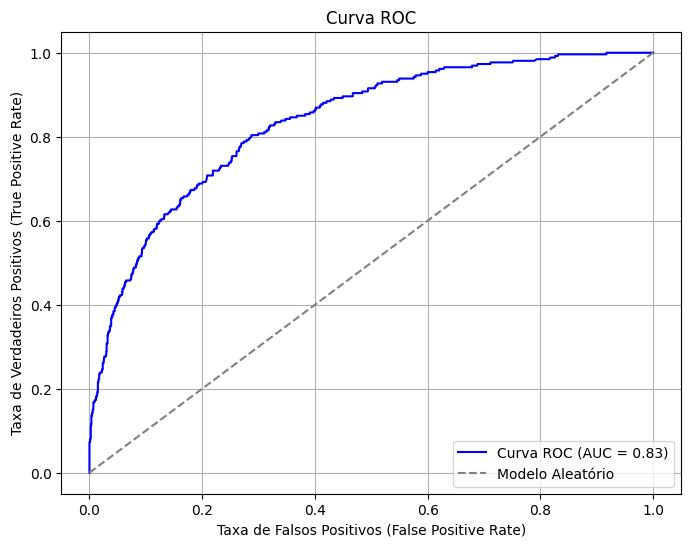

In [76]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Modelo Aleatório')
plt.xlabel('Taxa de Falsos Positivos (False Positive Rate)')
plt.ylabel('Taxa de Verdadeiros Positivos (True Positive Rate)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
# Interpretação:
# - A curva ROC mostra a habilidade do modelo em separar fraudes de não fraudes.
# - Quanto mais a curva se aproxima do canto superior esquerdo, melhor.
# - A linha diagonal representa um modelo aleatório (AUC = 0.5).

In [77]:
# ================================================
# PR AUC
# ================================================
# Como se calcula: Área sob a curva Precision-Recall (Precisão vs Recall).
# Vantagem? Mais robusta para classes raras (fraude).
# Desvantagem? Menos intuitiva para não técnicos.
# Quando não usar? Classes balanceadas.
# Quando usar? Fraude, churn, problemas com classe positiva rara.
# O que pode melhorar essa métrica? Balanceamento, ajuste de cutoff.
# Cuidado? Pode variar muito em datasets pequenos.
# Valor ideal:
#   - < 0.50 → Fraco
#   - 0.50 a 0.75 → Bom
#   - > 0.75 → Excelente
pr_auc = average_precision_score(y_true, y_proba)
print("PR AUC:", pr_auc)

PR AUC: 0.5049293141687562


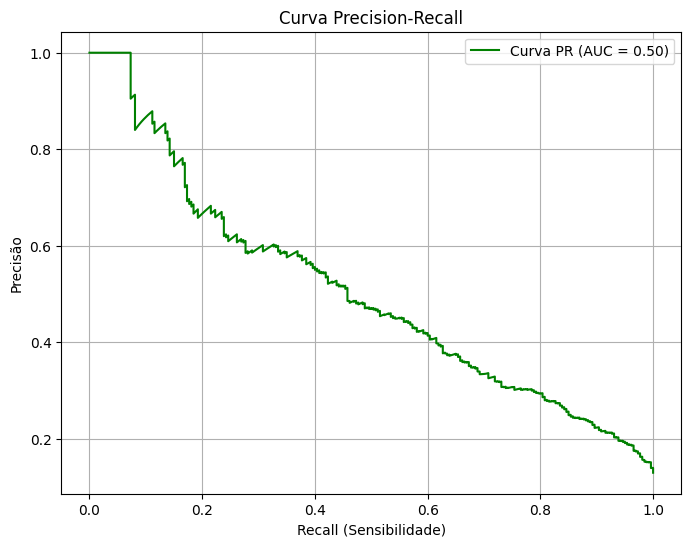

In [79]:
# Curva Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label=f'Curva PR (AUC = {pr_auc:.2f})')
plt.xlabel('Recall (Sensibilidade)')
plt.ylabel('Precisão')
plt.title('Curva Precision-Recall')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
# Interpretação:
# - A curva PR mostra a relação entre precisão e recall conforme mudamos o cutoff.
# - Ideal quando a classe positiva é rara (fraudes).
# - Curvas próximas ao canto superior direito indicam modelo excelente.

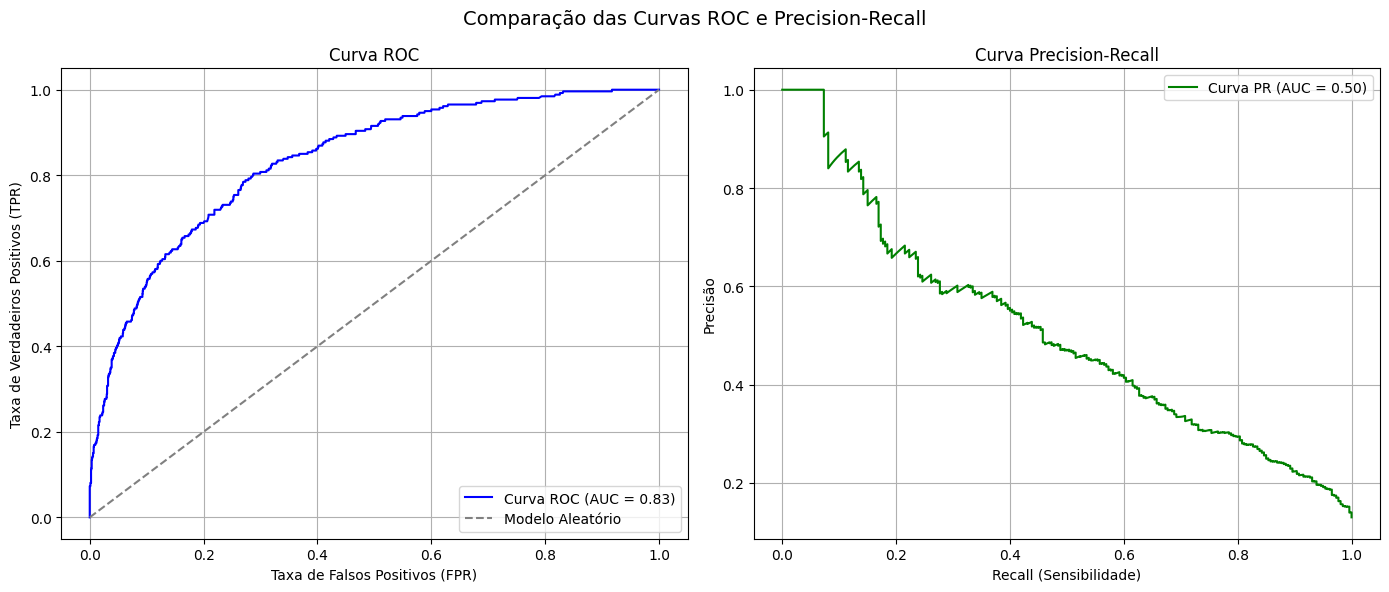

In [80]:
# Calcular métricas
roc_auc = roc_auc_score(y_true, y_proba)
pr_auc = average_precision_score(y_true, y_proba)

# Calcular pontos para as curvas
fpr, tpr, _ = roc_curve(y_true, y_proba)
precision, recall, _ = precision_recall_curve(y_true, y_proba)

# Criar figura com 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# -------------------------------
# Curva ROC
# -------------------------------
axes[0].plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], color='gray', linestyle='--', label='Modelo Aleatório')
axes[0].set_xlabel('Taxa de Falsos Positivos (FPR)')
axes[0].set_ylabel('Taxa de Verdadeiros Positivos (TPR)')
axes[0].set_title('Curva ROC')
axes[0].legend(loc='lower right')
axes[0].grid(True)

# -------------------------------
# Curva Precision-Recall
# -------------------------------
axes[1].plot(recall, precision, color='green', label=f'Curva PR (AUC = {pr_auc:.2f})')
axes[1].set_xlabel('Recall (Sensibilidade)')
axes[1].set_ylabel('Precisão')
axes[1].set_title('Curva Precision-Recall')
axes[1].legend(loc='upper right')
axes[1].grid(True)

plt.suptitle('Comparação das Curvas ROC e Precision-Recall', fontsize=14)
plt.tight_layout()
plt.show()